# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [64]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = '1'

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [65]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10( # 과제: Dataset을 MNIST에서 CIFAR10으로 변경해줍니다.
	root='./data',
	train=True,
	download=True,
	transform=transform
)

Files already downloaded and verified


Test Set 데이터 로드

In [66]:
testSet = torchvision.datasets.CIFAR10(
	root='./data',
	train=False,
	download=True,
	transform=transform
)

Files already downloaded and verified


MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

50000
torch.Size([3, 32, 32]) 6


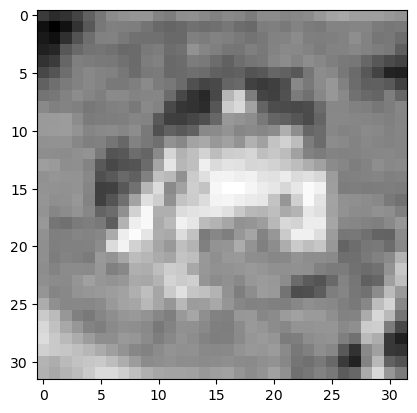

In [67]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1]) # 과제: CIFAR10의 입력 shape 확인
plt.imshow(trainset[0][0][0], cmap='gray')

Test Set 미리보기

10000
torch.Size([3, 32, 32]) 3


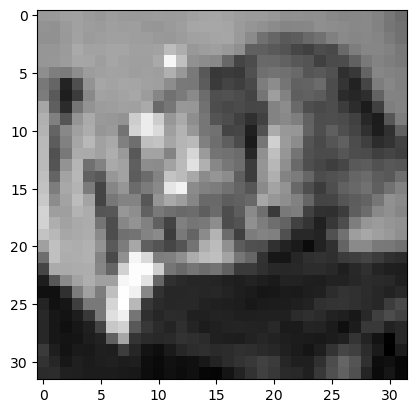

In [68]:
print(len(testSet))
print(testSet[0][0].shape, testSet[0][1]) # testSet[데이터 인덱스][0: 데이터, 1: 라벨]
plt.imshow(testSet[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [69]:
batch_size = 256 # 과제: 학습 인자는 n_epochs = 50, batch_size = 256로 설정합니다.

trainloader = torch.utils.data.DataLoader(
	trainset,
	batch_size=batch_size,
	shuffle=True
)

Test Data

In [70]:
testLoader = torch.utils.data.DataLoader(
	testSet,
	batch_size=batch_size,
	shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [71]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [77]:
from torch import nn

class Model(nn.Module): # nn.Modlue 상속
	def __init__(self, input_dim, n_dim):
		super().__init__()

		self.layer1 = nn.Linear(input_dim, n_dim)
		self.layer2 = nn.Linear(n_dim, n_dim)
		self.layer3 = nn.Linear(n_dim, 10)
		self.act = nn.LeakyReLU() # 과제:  Activation 함수를 nn.ReLU에서 nn.LeakyReLU로 변경해줍니다.

	def forward(self, x):
		x = torch.flatten(x, start_dim=1)
		x = self.act(self.layer1(x))
		x = self.act(self.layer2(x))
		x = self.act(self.layer3(x))
		return x

def accuracy(model, dataloader):
	with torch.no_grad():
		model.eval()
		cnt = 0
		acc = 0

		for data in dataloader:
			inputs, labels = data
			inputs, labels = inputs.to('cuda'), labels.to('cuda')

			preds = model(inputs)
			preds = torch.argmax(preds, dim=-1)

			cnt += labels.shape[0]
			acc += (labels == preds).sum().item()

		return acc / cnt

model = Model(32 * 32 * 3, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [78]:
from torch.optim import SGD

lr = 0.001
model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [79]:
from torch.optim import Adam

optimizerAdam = Adam(model.parameters(), lr=lr)

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [80]:
trainAccuracyList = []
testAccuracyList = []

# 손실함수 정의 (criterion ?)
lossFunction = nn.CrossEntropyLoss()

n_epochs = 50 # 과제: 학습 인자는 n_epochs = 50, batch_size = 256로 설정합니다.
print(batch_size)
for epoch in range(n_epochs):
	total_loss = 0.
	model.train()
	for data in trainloader:
		model.zero_grad()
		inputs, labels = data
		inputs, labels = inputs.to('cuda'), labels.to('cuda')

		preds = model(inputs)
		loss = lossFunction(preds, labels)
		#loss = (preds[:, 0] - labels).pow(2).mean() # MSE
		loss.backward()
		optimizer.step()

		total_loss += loss.item()
	print(f"Epoch {epoch:3d} | Loss: {total_loss}")
	trainAccuracyList.append(accuracy(model, trainloader))
	testAccuracyList.append(accuracy(model, testLoader))

256
Epoch   0 | Loss: 450.84932041168213
Epoch   1 | Loss: 449.6805033683777
Epoch   2 | Loss: 448.7265303134918
Epoch   3 | Loss: 447.7762379646301
Epoch   4 | Loss: 446.78612995147705
Epoch   5 | Loss: 445.4153606891632
Epoch   6 | Loss: 443.52308464050293
Epoch   7 | Loss: 441.73318815231323
Epoch   8 | Loss: 439.91439414024353
Epoch   9 | Loss: 438.00374460220337
Epoch  10 | Loss: 435.91953587532043
Epoch  11 | Loss: 433.7324948310852
Epoch  12 | Loss: 431.35543966293335
Epoch  13 | Loss: 428.88167786598206
Epoch  14 | Loss: 426.355761051178
Epoch  15 | Loss: 423.68616676330566
Epoch  16 | Loss: 421.04148840904236
Epoch  17 | Loss: 418.3161175251007
Epoch  18 | Loss: 415.62695145606995
Epoch  19 | Loss: 412.9968855381012
Epoch  20 | Loss: 410.46519780158997
Epoch  21 | Loss: 407.98581886291504
Epoch  22 | Loss: 405.66617465019226
Epoch  23 | Loss: 403.44561088085175
Epoch  24 | Loss: 401.3294289112091
Epoch  25 | Loss: 399.28499388694763
Epoch  26 | Loss: 397.3633620738983
Epoch  2

In [81]:
trainAdamAccuracyList = []
testAdamAccuracyList = []

for epoch in range(n_epochs):  #과제: 먼저 Adam optimizer을 사용하여 학습하는 코드를 구현합니다.
	total_loss = 0.
	model.train()
	for data in trainloader:
		model.zero_grad()
		inputs, labels = data
		inputs, labels = inputs.to('cuda'), labels.to('cuda')

		preds = model(inputs)
		loss = lossFunction(preds, labels)
		loss.backward()
		optimizerAdam.step()

		total_loss += loss.item()
	print(f"Epoch {epoch:3d} | Loss: {total_loss}")
	trainAdamAccuracyList.append(accuracy(model, trainloader))
	testAdamAccuracyList.append(accuracy(model, testLoader))

Epoch   0 | Loss: 457.1291482448578
Epoch   1 | Loss: 374.3499540090561
Epoch   2 | Loss: 330.8964158296585
Epoch   3 | Loss: 312.9250657558441
Epoch   4 | Loss: 302.0654448270798
Epoch   5 | Loss: 291.7374918460846
Epoch   6 | Loss: 285.07336711883545
Epoch   7 | Loss: 278.0374891757965
Epoch   8 | Loss: 272.3272076845169
Epoch   9 | Loss: 266.97212731838226
Epoch  10 | Loss: 261.3739060163498
Epoch  11 | Loss: 258.82901895046234
Epoch  12 | Loss: 253.49311685562134
Epoch  13 | Loss: 248.41821122169495
Epoch  14 | Loss: 244.8990956544876
Epoch  15 | Loss: 240.3044753074646
Epoch  16 | Loss: 235.38325822353363
Epoch  17 | Loss: 231.6789572238922
Epoch  18 | Loss: 229.00358390808105
Epoch  19 | Loss: 223.41357100009918
Epoch  20 | Loss: 220.19263887405396
Epoch  21 | Loss: 215.7106248140335
Epoch  22 | Loss: 213.24267518520355
Epoch  23 | Loss: 208.12278151512146
Epoch  24 | Loss: 205.74357157945633
Epoch  25 | Loss: 201.30723232030869
Epoch  26 | Loss: 196.99150532484055
Epoch  27 | Lo

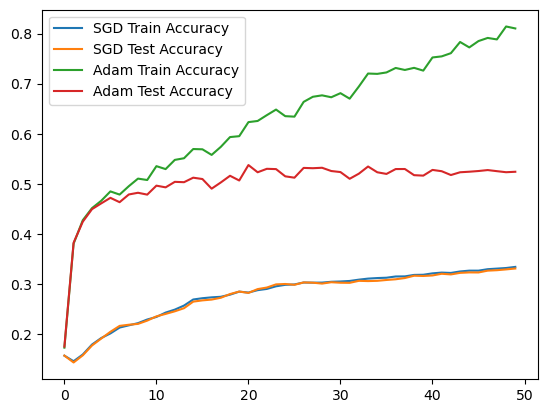

In [82]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
	x = np.arange(len(train_accs))

	plt.plot(x, train_accs, label=label1)
	plt.plot(x, test_accs, label=label2)
	plt.legend()
	plt.show()

def plotAccuracyTwo(trainAcc1, testAcc1, trainAcc2, testAcc2, model1Name = "Model 1", model2Name = " Model 2"):
	x = np.arange(len(trainAcc1))

	plt.plot(x, trainAcc1, label=f"{model1Name} Train Accuracy")
	plt.plot(x, testAcc1, label=f"{model1Name} Test Accuracy")
	plt.plot(x, trainAcc2, label=f"{model2Name} Train Accuracy")
	plt.plot(x, testAcc2, label=f"{model2Name} Test Accuracy")
	plt.legend()
	plt.show()

plotAccuracyTwo(trainAccuracyList, testAccuracyList, # 과제: (Plot 1) SGD와 Adam을 학습시킨 후 각각의 epoch에 대한 train 정확도를 plot합니다.
				trainAdamAccuracyList, testAdamAccuracyList, "SGD", "Adam")

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [83]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[ 1.1764e+00,  8.7799e-01, -5.0639e-03,  3.2663e+00,  2.6242e+00,
          6.5080e+00,  8.8516e+00,  2.1956e+00, -1.7448e-02, -4.4794e-02]],
       device='cuda:0', grad_fn=<LeakyReluBackward0>)
6


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

In [84]:
class ModelSigmoid(nn.Module): # 과제: Activation 함수가 nn.Sigmoid인 class를 새로 정의합니다.
	def __init__(self, input_dim, n_dim):
		super().__init__()

		self.layer1 = nn.Linear(input_dim, n_dim)
		self.layer2 = nn.Linear(n_dim, n_dim)
		self.layer3 = nn.Linear(n_dim, 10)
		self.act = nn.Sigmoid()

	def forward(self, x):
		x = torch.flatten(x, start_dim=1)
		x = self.act(self.layer1(x))
		x = self.act(self.layer2(x))
		x = self.act(self.layer3(x))
		return x

modelSigmoid = ModelSigmoid(32 * 32 * 3, 1024)
modelSigmoid = modelSigmoid.to('cuda')

optimizerAdam = Adam(modelSigmoid.parameters(), lr=lr)

trainSigmoidAccuracyList = []
testSigmoidAccuracyList = []

for epoch in range(n_epochs):
	total_loss = 0.
	modelSigmoid.train()
	for data in trainloader:
		modelSigmoid.zero_grad()
		inputs, labels = data
		inputs, labels = inputs.to('cuda'), labels.to('cuda')

		preds = modelSigmoid(inputs)
		loss = lossFunction(preds, labels)
		loss.backward()
		optimizerAdam.step()
		
		total_loss += loss.item()
	print(f"Epoch {epoch:3d} | Loss: {total_loss}")
	trainSigmoidAccuracyList.append(accuracy(modelSigmoid, trainloader))
	testSigmoidAccuracyList.append(accuracy(modelSigmoid, testLoader))

Epoch   0 | Loss: 413.2633179426193
Epoch   1 | Loss: 395.2151082754135
Epoch   2 | Loss: 387.79760336875916
Epoch   3 | Loss: 384.4010167121887
Epoch   4 | Loss: 382.3411934375763
Epoch   5 | Loss: 379.5269863605499
Epoch   6 | Loss: 378.86785554885864
Epoch   7 | Loss: 375.7839250564575
Epoch   8 | Loss: 375.2246652841568
Epoch   9 | Loss: 373.5121695995331
Epoch  10 | Loss: 372.14808201789856
Epoch  11 | Loss: 371.35579681396484
Epoch  12 | Loss: 370.24667179584503
Epoch  13 | Loss: 369.3408396244049
Epoch  14 | Loss: 368.73764753341675
Epoch  15 | Loss: 367.4538720846176
Epoch  16 | Loss: 366.911540389061
Epoch  17 | Loss: 366.03055799007416
Epoch  18 | Loss: 365.383624792099
Epoch  19 | Loss: 364.32856929302216
Epoch  20 | Loss: 364.12009358406067
Epoch  21 | Loss: 363.3215752840042
Epoch  22 | Loss: 362.70420503616333
Epoch  23 | Loss: 362.538801074028
Epoch  24 | Loss: 361.6614829301834
Epoch  25 | Loss: 360.76739490032196
Epoch  26 | Loss: 360.68213856220245
Epoch  27 | Loss: 3

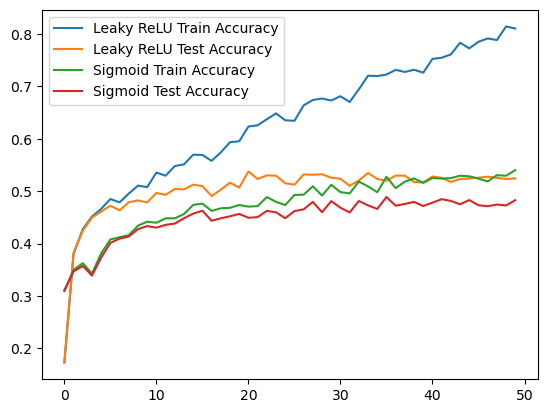

In [86]:
plotAccuracyTwo(trainAdamAccuracyList, testAdamAccuracyList, # 과제: (Plot 2) Adam optimizer를 가지고 sigmoid와 leaky ReLU 모델들을 학습한 후, epoch에 따른 train 정확도를 비교합니다.
				trainSigmoidAccuracyList, testSigmoidAccuracyList, "Leaky ReLU", "Sigmoid")

In [87]:
# 과제: PyTorch dropout을 leaky ReLU를 사용하는 MLP의 모든 layer에 적용한 class를 새로 정의합니다. Dropout 확률은 0.1로 설정합니다.

class ModelDropout(nn.Module): # nn.Modlue 상속
	def __init__(self, input_dim, n_dim, dropoutRate = 0.1):
		super().__init__()

		self.layer1 = nn.Linear(input_dim, n_dim)
		self.layer2 = nn.Linear(n_dim, n_dim)
		self.layer3 = nn.Linear(n_dim, 10)
		self.act = nn.LeakyReLU()
		self.dropout = nn.Dropout(dropoutRate)

	def forward(self, x):
		x = torch.flatten(x, start_dim=1)
		x = self.act(self.layer1(x))
		x = self.dropout(x)   
		x = self.act(self.layer2(x))
		x = self.dropout(x)
		x = self.act(self.layer3(x))
		x = self.dropout(x)
		return x
	

In [88]:
modelDropout = ModelDropout(32 * 32 * 3, 1024)
modelDropout = modelDropout.to('cuda')

optimizerAdam = Adam(modelDropout.parameters(), lr=lr)

trainDropoutAccuracyList = []
testDropoutAccuracyList = []

for epoch in range(n_epochs):
	total_loss = 0.
	modelDropout.train()
	for data in trainloader:
		modelDropout.zero_grad()
		inputs, labels = data
		inputs, labels = inputs.to('cuda'), labels.to('cuda')

		preds = modelDropout(inputs)
		loss = lossFunction(preds, labels)
		loss.backward()
		optimizerAdam.step()

		total_loss += loss.item()
	print(f"Epoch {epoch:3d} | Loss: {total_loss}")
	trainDropoutAccuracyList.append(accuracy(modelDropout, trainloader))
	testDropoutAccuracyList.append(accuracy(modelDropout, testLoader))

Epoch   0 | Loss: 436.5150079727173
Epoch   1 | Loss: 413.31029748916626
Epoch   2 | Loss: 399.98622703552246
Epoch   3 | Loss: 391.04815649986267
Epoch   4 | Loss: 385.5977796316147
Epoch   5 | Loss: 379.8725520372391
Epoch   6 | Loss: 374.50124049186707
Epoch   7 | Loss: 370.77203714847565
Epoch   8 | Loss: 368.174334526062
Epoch   9 | Loss: 364.7307790517807
Epoch  10 | Loss: 360.766810297966
Epoch  11 | Loss: 359.0680091381073
Epoch  12 | Loss: 356.26373982429504
Epoch  13 | Loss: 352.5354300737381
Epoch  14 | Loss: 352.67564845085144
Epoch  15 | Loss: 348.84801506996155
Epoch  16 | Loss: 347.7894238233566
Epoch  17 | Loss: 345.0462008714676
Epoch  18 | Loss: 344.130499958992
Epoch  19 | Loss: 342.8766597509384
Epoch  20 | Loss: 339.49247574806213
Epoch  21 | Loss: 338.92770743370056
Epoch  22 | Loss: 335.6535898447037
Epoch  23 | Loss: 334.83371353149414
Epoch  24 | Loss: 333.52661740779877
Epoch  25 | Loss: 332.66508316993713
Epoch  26 | Loss: 332.6080837249756
Epoch  27 | Loss: 

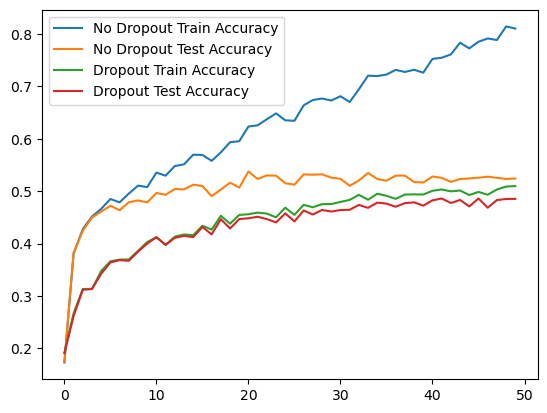

In [89]:
plotAccuracyTwo(trainAdamAccuracyList, testAdamAccuracyList, #과제: (Plot 3) Adam optimizer를 가지고 dropout을 적용한 모델을 학습한 후, epoch에 따른 train과 test 정확도를 비교합니다.
				trainDropoutAccuracyList, testDropoutAccuracyList, "No Dropout", "Dropout")
